---
format: 
  html:
    toc: true
    code-fold: true
    code-summary: "Show/Hide Code"
    warning: false
execute:
  echo: true
---

# Optimizing Bike-Sharing Operations: Insights of CitiBike in Manhattan Using Data-Driven Analysis

## Background

Citi Bike is New York City's largest bike-sharing system, offering residents and tourists an affordable, sustainable, and efficient transportation alternative. Since its launch in 2013, Citi Bike has grown significantly, with thousands of bikes and hundreds of docking stations across Manhattan, Brooklyn, Queens, and other boroughs. As the demand for bike-sharing services continues to rise, there is a pressing need to analyze usage patterns, revenue generation, and network accessibility to enhance operational efficiency and user experience.

This project leverages trip data from Citi Bike for July 2024, focusing specifically on Manhattan. Manhattan serves as a critical area of analysis due to its high population density, diverse user base, and complex transportation dynamics. By analyzing trip data and integrating it with geospatial network information, this project aims to uncover key insights into ridership behavior, evaluate station accessibility, and identify opportunities to optimize the system's operations and revenue.

## Motivation

The motivation behind this project stems from several key factors:

- Sustainability and Urban Mobility: Citi Bike plays a vital role in promoting sustainable transportation in one of the world's busiest cities. Understanding usage patterns and station accessibility can help policymakers and planners expand the bike network effectively, reducing car dependency and lowering carbon emissions.

- Data-Driven Optimization: Citi Bike's operations involve complex logistical challenges, including balancing bike distribution across stations, maintaining infrastructure, and optimizing pricing models. This project uses data-driven methods to evaluate station coverage, ridership trends, and revenue streams, providing actionable recommendations for operational improvement.

- Improving User Experience: By analyzing trip durations, weather impacts, and station-level trends, the project aims to identify factors influencing user satisfaction. Insights into peak usage times, station demand, and accessibility gaps can help enhance user convenience and attract more riders.



## Goals and Objectives
- Ridership Analysis: Analyze daily and hourly trends in Citi Bike trips to identify peak times and seasonal usage patterns.

- Station Accessibility: Evaluate station coverage by integrating trip data with Manhattan's bike network, calculating metrics like nearest nodes and coverage buffers.

- Revenue Assessment: Calculate revenue based on Citi Bike's pricing structure, identifying top-performing stations and ride types that contribute to financial success.

- Impact of Weather: Investigate the relationship between weather conditions (e.g., temperature and precipitation) and ridership behavior.

## Ridership and Membership Analysis

The Citi Bike data reveals intriguing temporal trends in daily ridership. The chart titled Daily Ridership Trends demonstrates that the highest ridership occurred on weekdays, particularly July 1st and July 10th, corresponding to Monday and Wednesday, respectively. These peaks reflect the system's role in supporting Manhattan’s weekday commuter base. The midweek ridership stability showcases Citi Bike's seamless integration into the city’s transportation ecosystem for office workers, students, and other routine commuters.

However, the sharp dip during the weekend (July 6th–7th) signals an underutilized potential for leisure trips. With Manhattan hosting several tourist hotspots and vibrant weekend activities, the absence of a proportional rise in leisure ridership on weekends is noteworthy. This suggests that Citi Bike could improve its outreach to tourists and casual users who might otherwise opt for taxis or public transit. Offering targeted weekend packages, promoting bike tours, or collaborating with cultural and recreational events could help bridge this gap.

Interestingly, the overall average of 90,000 daily trips highlights the resilience and reliability of Citi Bike’s operations. Despite varying weather conditions and external factors, the consistent demand underscores its importance to New Yorkers.

The membership distribution paints a striking picture of Citi Bike’s user base. Members contribute 77.3% of all trips, far outweighing the 22.7% share of casual users. This divide is both a strength and a vulnerability. While the loyalty and frequent usage of members stabilize revenue streams, the low proportion of casual riders points to untapped market potential.

Critically, casual users are an important demographic for expanding Citi Bike's reach. Their occasional use might stem from perceived barriers, such as unfamiliarity with the system or a lack of compelling benefits to join as members. By targeting these riders with discounts, loyalty programs, or easier onboarding processes, Citi Bike can create a pathway for casual users to transition into long-term subscribers. Creative solutions such as gamification (e.g., earning badges for rides) or bundling memberships with other services (e.g., public transit passes) could further bolster membership numbers.

/var/folders/91/fw6j_j153bv0ybx1rzlkpy2r0000gn/T/ipykernel_18913/1320610592.py:22: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv(data_path1)
/var/folders/91/fw6j_j153bv0ybx1rzlkpy2r0000gn/T/ipykernel_18913/1320610592.py:23: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv(data_path2)
/Users/shuaiwang/anaconda3/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/shuaiwang/anaconda3/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/shuaiwang/anaconda3/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(

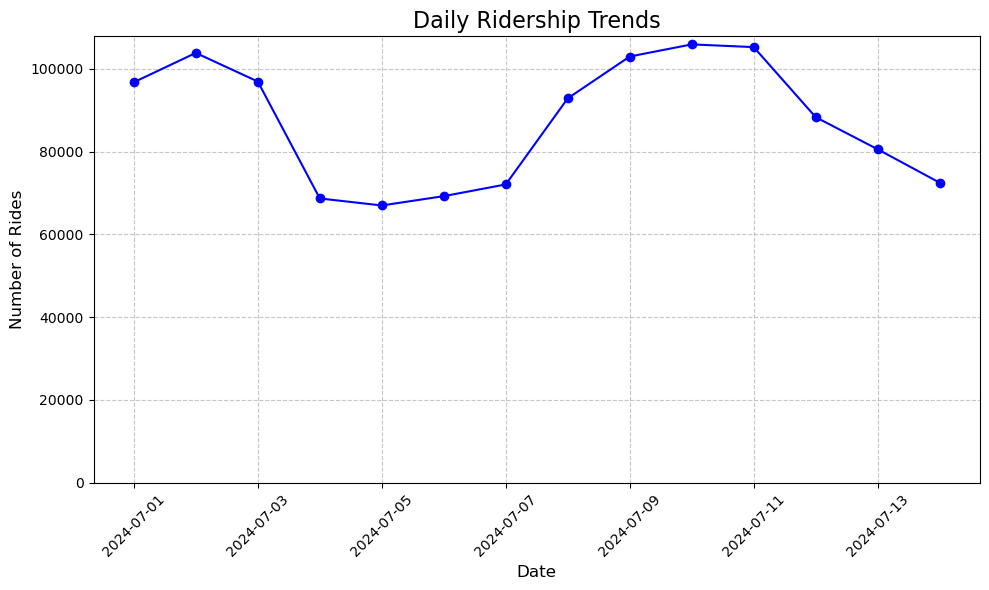

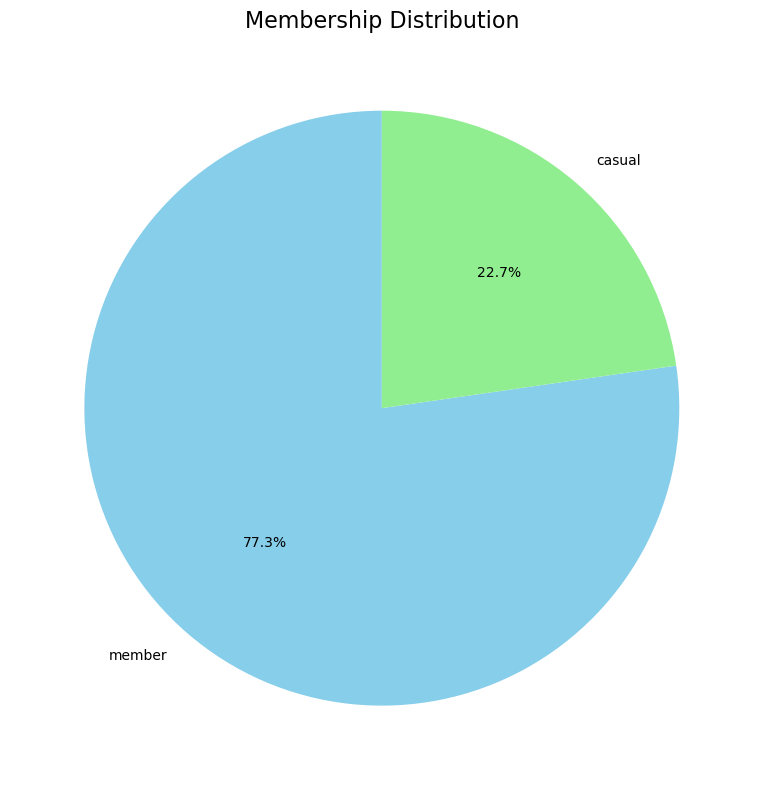

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import geopandas as gpd
from datetime import datetime
import requests
import osmnx as ox
from shapely.geometry import Polygon, Point
import hvplot.pandas
import pandana as pdna
import  folium
from branca.colormap import LinearColormap
from folium.plugins import MousePosition
import xyzservices

pd.set_option('display.float_format', '{:.2f}'.format)
# Load Citi Bike trip data (July 2024 dataset preview)
data_path1 = '202407-citibike-tripdata/202407-citibike-tripdata_1.csv'
data_path2 = '202407-citibike-tripdata/202407-citibike-tripdata_2.csv'
data1 = pd.read_csv(data_path1)
data2 = pd.read_csv(data_path2)

trips = pd.concat([data1, data2], ignore_index=True)
trips = trips[(trips['started_at'] >= '2024-07-01') & (trips['started_at'] <= '2024-07-15')]

# Convert date columns to datetime format
trips['started_at'] = pd.to_datetime(trips['started_at'])
trips['ended_at'] = pd.to_datetime(trips['ended_at'])

# Calculate trip duration in minutes
trips['trip_duration'] = (trips['ended_at'] - trips['started_at']).dt.total_seconds() / 60
# Remove invalid trips (negative or zero duration)
trips = trips[trips['trip_duration'] > 0]

# Fetch Historical Weather Data using NOAA API
noaa_token = 'hiHwlLQdHGzOdZvDUHqynSFScHvhaaAd'  
weather_url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'

# Function to fetch NOAA weather data
def fetch_noaa_weather(start_date, end_date, station_id):
    headers = {'token': noaa_token}
    params = {
        'datasetid': 'GHCND',
        'datatypeid': ['TMAX', 'TMIN', 'PRCP'],
        'stationid': station_id,
        'startdate': start_date,
        'enddate': end_date,
        'units': 'metric',
        'limit': 1000
    }
    response = requests.get(weather_url, headers=headers, params=params)
    if response.status_code == 200:
        return pd.DataFrame(response.json()['results'])
    else:
        print(f"Error: {response.status_code} {response.text}")
        return pd.DataFrame()

# Fetch weather data for July 2024
station_id = 'GHCND:USW00094728'  # NOAA station ID for Central Park, NYC
weather_data = fetch_noaa_weather('2024-07-01', '2024-07-31', station_id)

# Pivot weather data to have TMAX, TMIN, and PRCP as columns
weather_summary = weather_data.pivot_table(
    index='date',
    columns='datatype',
    values='value',
    aggfunc='mean'
).reset_index()

weather_summary.columns = ['date', 'precipitation', 'temp_max', 'temp_min']
weather_summary['date'] = pd.to_datetime(weather_summary['date']).dt.date

# Merge weather data with Citi Bike data
trips = trips.merge(weather_summary, left_on=trips['started_at'].dt.date, right_on='date', how='left')

## Geospatial Data Integration
# Load NYC bike network data
G = ox.graph_from_place('Manhattan, New York, USA', network_type='bike')
# Convert the network graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
nyc = pd.read_csv('2020_Census_Tracts_20241221.csv')
manhattan = nyc[nyc['BoroCode'] == 1]
from shapely.wkt import loads
manhattan['geometry'] = manhattan['the_geom'].apply(loads).drop(columns=['the_geom'])
manhattan = gpd.GeoDataFrame(manhattan, geometry='geometry', crs='EPSG:4326')
manhattan = manhattan[['CTLabel', 'geometry']]
# Add bike lane coverage data
trips = gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.start_lng, trips.start_lat), crs='EPSG:4326')
# Perform spatial join to keep only trips in Manhattan
trips = gpd.sjoin(trips, manhattan, how='inner', op='intersects')
trips['nearest_node'] = ox.distance.nearest_nodes(G, trips.geometry.x, trips.geometry.y)
# Get the list of valid nodes from the Manhattan graph G
manhattan_nodes = set(G.nodes)
# Filter stations to include only those with a nearest node in the Manhattan graph
trips = trips[trips['nearest_node'].isin(manhattan_nodes)]
# Reset the index after filtering
trips = trips.reset_index(drop=True)

# Ridership and Membership Analysis
# Daily ridership and member contributions
rides_per_day = trips.groupby(trips['started_at'].dt.date)['ride_id'].count()
members_vs_casuals = trips['member_casual'].value_counts()

# Plot daily ridership trends
plt.figure(figsize=(10, 6))
rides_per_day.plot(kind='line', marker='o', color='blue')

# Customize the plot
plt.title('Daily Ridership Trends', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Rides', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.tight_layout()

# Show the plot
plt.show()

# Plot membership distribution
plt.figure(figsize=(8, 8))
members_vs_casuals.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])

# Customize the plot
plt.title('Membership Distribution', fontsize=16)
plt.ylabel('')  # Remove the default y-axis label
plt.tight_layout()

# Show the plot
plt.show()

## Weather Impact on Customer Behavior

The influence of weather on ridership cannot be overstated. The chart Temperature vs. Ridership reveals a modest decline in ridership as temperatures exceed 30°C, emphasizing the discomfort associated with cycling during extreme heat. Riders appear to prefer moderate temperatures, with the sweet spot lying between 27°C and 29°C. This highlights a unique challenge: while bike usage peaks during favorable weather conditions, extreme heat—common during New York’s summers—may reduce ridership.

The chart Precipitation vs. Ridership offers  more insights. Days with any significant rainfall experienced moderate reductions in ridership, while some slight rain has very limited impact on ridership. This underscores the reliance of Citi Bike on fair-weather riders and raises the question of how to maintain ridership during adverse conditions.

Citi Bike could mitigate these impacts by implementing weather-responsive strategies. For example, offering discounts or loyalty points on rainy days could encourage usage even during light rain. Additionally, providing weather protection gear such as rain ponchos or collaborating with local stores to offer discounts for riders could reduce the deterrent effect of precipitation.

/Users/shuaiwang/anaconda3/envs/musa-550-fall-2023/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


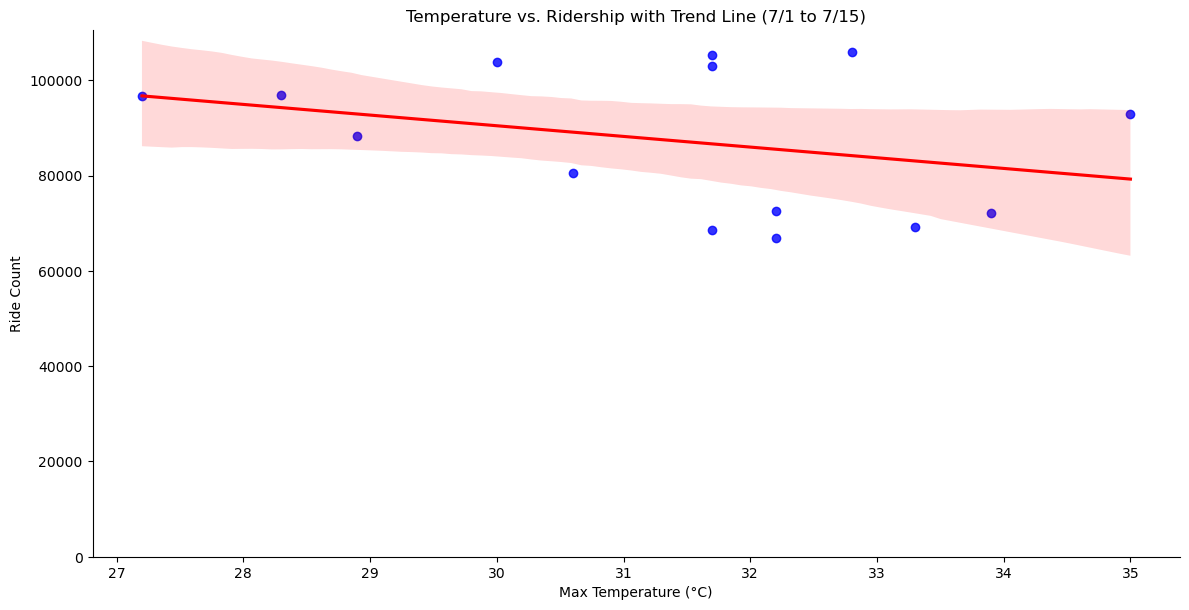

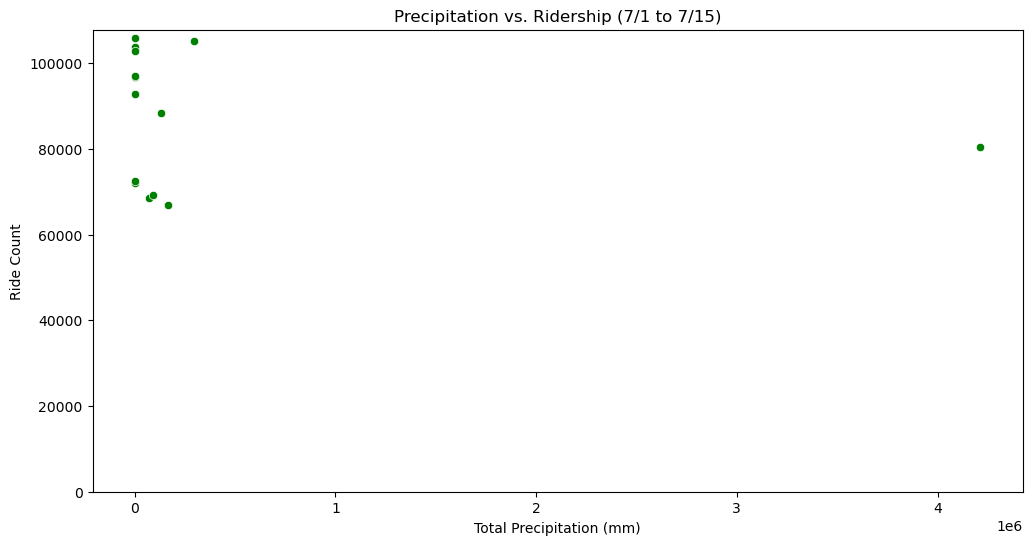

In [132]:
# Analyze ridership under different weather conditions
weather_impact = trips.groupby('date').agg(
    ride_count=('ride_id', 'size'),
    max_temp=('temp_max', 'max'),
    total_precip=('precipitation', 'sum')
).reset_index()

# Line plot with regression: Temperature vs. Average Daily Ridership
sns.lmplot(x='max_temp', y='ride_count', data=weather_impact, aspect=2, height=6, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.title('Temperature vs. Ridership with Trend Line (7/1 to 7/15)')
plt.xlabel('Max Temperature (°C)')
plt.ylabel('Ride Count')
plt.ylim(bottom=0)
plt.show()
# Scatter plot: Precipitation vs. Ridership
plt.figure(figsize=(12, 6))
sns.scatterplot(x='total_precip', y='ride_count', data=weather_impact, color='green')
plt.title('Precipitation vs. Ridership (7/1 to 7/15)')
plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Ride Count')
plt.ylim(bottom=0)
plt.show()

## Revenue Analysis

The horizontal bar chart Top 10 Stations by Revenue underscores a stark revenue concentration at a few key stations. Stations near Central Park (7 Ave & Central Park South, Central Park S & 6 Ave) consistently generated the highest revenue, followed closely by West St & Chambers St in the financial district. These findings highlight the dual role of Citi Bike stations: supporting commuting in business hubs and catering to leisure activities near tourist destinations.

Interestingly, the revenue disparity between high-performing and low-performing stations raises questions about station placement. While some stations thrive due to their strategic locations, others may struggle due to poor connectivity, low foot traffic, or limited bike availability. By analyzing underperforming stations in conjunction with ridership patterns, Citi Bike could optimize station placement and redistribute underused assets to high-demand areas.

Furthermore, the concentration of revenue at a few stations underscores the need for dynamic resource allocation. High-performing stations require frequent bike redistribution and maintenance to ensure uninterrupted service during peak hours.

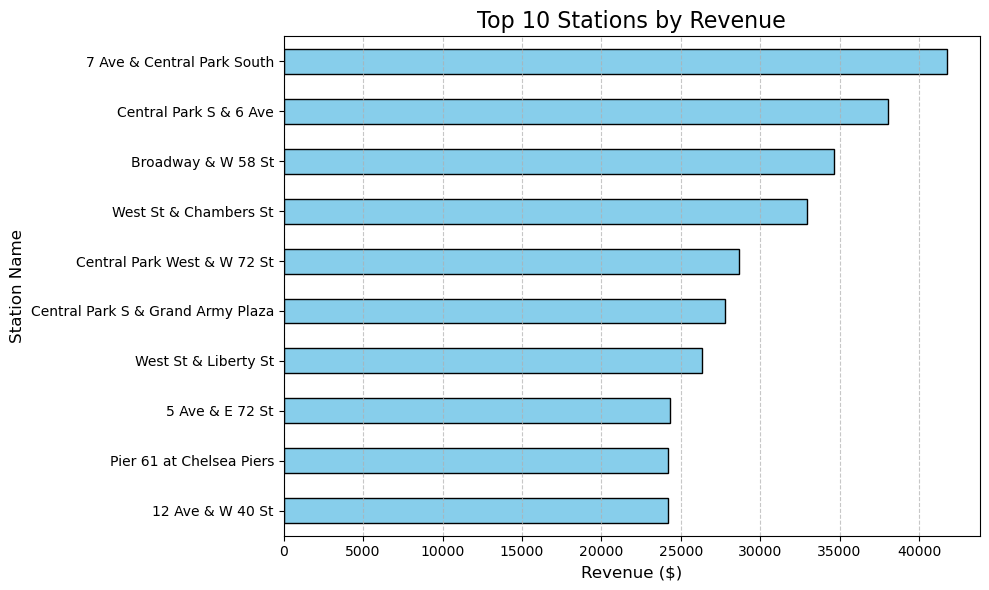

In [133]:
# Pricing logic based on Citi Bike pricing
# Single Ride: $4.79 for 30 minutes, $0.36/min thereafter
# Day Pass: $19/day with unlimited 30-minute rides, $4 every 15 minutes after 30 minutes
# Citi Bike Annual Member: $219.99/year, $0.24/min for e-bikes
# Lyft Pink Member: $199/year, $0.24/min for e-bikes
def calculate_revenue(row):
    if row['member_casual'] == 'casual':
        if row['trip_duration'] <= 30:
            return 4.79  # Flat fee for single rides
        else:
            return 4.79 + 0.36 * (row['trip_duration'] - 30)  # Extra charge after 30 mins
    elif row['member_casual'] == 'member':
        return 0.24 * row['trip_duration']  # Per-minute charge for e-bikes
    else:
        return 0  # Default if no valid category
    
trips['revenue'] = trips.apply(calculate_revenue, axis=1)
total_revenue = trips['revenue'].sum()
#print(f'Total Revenue: ${total_revenue}')
# Station Performance
station_revenue = trips.groupby('start_station_name')['revenue'].sum().sort_values(ascending=False)
top_stations = station_revenue.head(10)
# Plot a horizontal bar chart
plt.figure(figsize=(10, 6))
top_stations.plot(kind='barh', color='skyblue', edgecolor='black')
# Add labels and title
plt.title('Top 10 Stations by Revenue', fontsize=16)
plt.xlabel('Revenue ($)', fontsize=12)
plt.ylabel('Station Name', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
# Show the plot
plt.tight_layout()
plt.show()

## Customer Segmentation

The table Customer Segments provides an in-depth look at Citi Bike’s user base, categorized into two distinct clusters. Casual users, represented by Cluster 0, take significantly longer trips (24.12 minutes on average) but contribute fewer total trips (277,748). This cluster aligns with leisure-oriented riders who likely use Citi Bike for recreation or occasional errands.

In contrast, Cluster 1, dominated by members, reflects a commuter-driven behavior. With an average trip duration of 12.23 minutes and a total trip count of 945,056, this cluster underscores the reliance of Citi Bike on short, frequent trips by daily commuters. Members likely use Citi Bike as a last-mile solution, connecting subway stations or buses to their workplaces.

These insights have profound implications for marketing and operational strategies. For casual users, Citi Bike could promote longer leisure rides through partnerships with tourist attractions or cultural sites. For members, enhancing commuter-centric services, such as guaranteed bike availability during rush hours, could further cement their loyalty.



In [134]:
# K-Means Clustering for Customer Segmentation
# Features: Average trip duration, trip count
user_features = trips.groupby('member_casual').agg(
    avg_duration=('trip_duration', 'mean'),
    trip_count=('ride_id', 'count')
).reset_index()

kmeans = KMeans(n_clusters=2, random_state=42)
user_features['cluster'] = kmeans.fit_predict(user_features[['avg_duration', 'trip_count']])

from IPython.display import display

# Define a mapping for cluster labels to make them more descriptive
cluster_labels = {
    0: "High Duration, Low Trip Count (Casual Users)",
    1: "Low Duration, High Trip Count (Members)"
}

# Add descriptive cluster labels
user_features['cluster_label'] = user_features['cluster'].map(cluster_labels)

# Format the table with renamed columns for better presentation
segmentation_table = user_features.rename(columns={
    'member_casual': 'User Type',
    'avg_duration': 'Average Trip Duration (mins)',
    'trip_count': 'Total Trip Count',
    'cluster_label': 'Segment Description'
}).drop(columns=['cluster'])

# Display the table
print("\nCustomer Segmentation Table:")
display(segmentation_table)


Customer Segmentation Table:


/Users/shuaiwang/anaconda3/envs/musa-550-fall-2023/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,User Type,Average Trip Duration (mins),Total Trip Count,Segment Description
0,casual,24.12,277748,"High Duration, Low Trip Count (Casual Users)"
1,member,12.23,945056,"Low Duration, High Trip Count (Members)"


## Station Performance and Connectivity Analysis

The distribution of total trips reveals a strong concentration of high-performing stations in central Manhattan, particularly in areas such as Midtown, Central Park, and the Financial District. Stations near Central Park, including 7 Ave & Central Park South and Central Park S & 6 Ave, continue to stand out as major hubs, aligning with previous revenue analyses. These stations attract a mix of commuter and leisure riders, leveraging their strategic location near residential areas, office spaces, and tourist attractions.

On the other hand, stations in the Upper Manhattan region and the peripheral areas of Lower Manhattan demonstrate relatively lower activity. This discrepancy may be attributed to a combination of factors, such as lower population density, limited tourist attractions, or weaker connectivity to bike lanes and public transit hubs. For example, stations along the northern parts of the island might benefit from targeted campaigns to encourage usage among nearby residents and commuters.

The analysis also highlights several outlier stations with unusually high total trips. These stations may serve as critical redistribution points in the network, playing an outsized role in balancing bike availability across Manhattan. Such patterns underscore the need for Citi Bike to focus resources on maintaining and scaling these high-demand locations.

A significant and promising finding is that all Citi Bike stations in Manhattan are connected to a bike lane within 100 meters. This high level of connectivity is critical for ensuring the system’s usability and safety. The seamless integration with Manhattan’s extensive bike lane network provides riders with a safe and convenient experience, minimizing interactions with vehicle traffic.

The proximity to bike lanes plays a pivotal role in encouraging ridership, particularly for casual users who may feel less confident cycling in mixed traffic conditions. Stations with strong connectivity to bike lanes often exhibit higher trip counts, reinforcing the importance of station placement near well-developed cycling infrastructure.

From a policy perspective, these findings validate the city’s ongoing efforts to expand and enhance its bike lane network. Further investments in bike lane infrastructure, particularly in regions with low ridership, could help improve station utilization and support Citi Bike’s growth.

In [135]:
# Calculate average ridership per station
#station = trips.groupby('start_station_id')['ride_id'].count().reset_index()
station = trips.groupby(['start_station_name', 'start_station_id']).agg({
    'ride_id': 'count',                # Total trips
    'geometry': 'first',  # Keep the geometry of each station
    'trip_duration': 'mean',           # Average trip duration
    'precipitation': 'mean',           # Average precipitation
    'temp_max': 'mean',                # Average max temperature
    'geometry': 'first',               # Keep the first geometry for mapping
    'nearest_node' : 'first',
}).reset_index()

# Rename columns for clarity
station.rename(columns={
    'ride_id': 'total_trips',
    'trip_duration': 'avg_trip_duration',
    'precipitation': 'avg_precipitation',
    'temp_max': 'avg_temp_max'
}, inplace=True)
# Ensure the result is a GeoDataFrame
station = gpd.GeoDataFrame(station, geometry='geometry',crs='EPSG:4326')
# Reproject stations and edges to a CRS with units
edges = edges.to_crs(epsg=4326)
# Calculate the nearest edge for each station
station['nearest_edge'] = station.geometry.apply(
    lambda geom: ox.distance.nearest_edges(G, geom.x, geom.y)
)
# Ensure 'u' and 'v' columns exist by resetting the index
edges = edges.reset_index()
# Extract the geometry of the nearest edge for each station
station['nearest_edge_geom'] = station['nearest_edge'].apply(
    lambda edge: edges.loc[(edges['u'] == edge[0]) & (edges['v'] == edge[1]), 'geometry'].values[0]
)
# Get the geometry of the nearest edge for each station
station['nearest_edge_geom'] = station['nearest_edge'].apply(
    lambda edge: edges.loc[(edges['u'] == edge[0]) & (edges['v'] == edge[1]), 'geometry'].values[0]
)
# Calculate the distance to the nearest bike lane
station['distance_to_bike_lane'] = station.apply(
    lambda row: row.geometry.distance(row.nearest_edge_geom), axis=1
)

# Add connectivity flag: 1 if connected (within 50 meters), 0 otherwise
station['connected_to_bike_lane'] = (station['distance_to_bike_lane'] <= 500).astype(int)
# Summary statistics
connected_count = station['connected_to_bike_lane'].sum()
total_stations = len(station)
#print(f"Connected stations: {connected_count} / {total_stations} ({(connected_count / total_stations) * 100:.2f}%)")
# Drop the `nearest_edge_geom` column to avoid serialization issues
station_m = station.drop(columns=['nearest_edge_geom'])
m = station_m.explore(
    column='total_trips',  # Color stations by total trips
   # cmap='Accent',
    tooltip=['start_station_name', 'total_trips', 'avg_trip_duration'],
    style_kwds={"weight": 2,  "fillOpacity": 0.6},
    name="Stations Coverage",
    tiles=xyzservices.providers.CartoDB.DarkMatter,
)
# Add a base map using folium
map_center = [station_m.geometry.y.mean(), station_m.geometry.x.mean()]
#base_map = folium.Map(location=map_center, zoom_start=12, tiles="CartoDB.Positron")
# Add the street network to the map
m

## Conclusion and Recommendations

This spatial analysis underscores the success of Citi Bike’s station placement strategy in Manhattan, particularly its integration with the city’s bike lane network. The combination of strong connectivity, strategic locations, and dual-purpose usage patterns for commuters and leisure riders makes Citi Bike an indispensable part of New York City's transportation landscape. By addressing disparities in station performance and continuing to align with Manhattan’s bike lane expansion, Citi Bike can further enhance its usability, sustainability, and user satisfaction. Here are the recommendations from the analysis to improve the operations of Citibikes:

1. Expand Infrastructure in High-Demand Areas
Central Park and Midtown:The analysis highlights that stations near Central Park and Midtown are consistently high-performing in terms of revenue and trip counts. Expanding capacity at these stations by adding more docks and bikes can alleviate pressure during peak times. Introducing additional stations in nearby areas can distribute demand more evenly and reduce congestion.
Financial District: Stations in the financial district also generate significant revenue, likely driven by commuting patterns. Adding more stations or expanding existing ones in this area can cater to the growing commuter demand.

2. Optimize Underperforming Stations
Northern and Peripheral Manhattan: Launch targeted marketing campaigns to raise awareness about these stations; Partner with local businesses or community organizations to integrate these stations into daily life.
Relocation or Redistribution:
For persistently underperforming stations, consider relocating them to areas with higher foot traffic or better connectivity to bike lanes.

3. Leverage Weather-Responsive Strategies
Weather-Based Incentives: Ridership drops significantly during rainy days and extreme heat. Offering discounts or loyalty points on rainy days could encourage usage, even in unfavorable weather conditions.
Gear and Comfort Enhancements: Provide riders with rain ponchos or collaborate with local stores to offer discounts on weather gear for riders.; Introduce shaded docking stations in high-traffic areas to improve comfort during summer.

4. Strengthen Member Engagement
Convert Casual Users to Members:
Casual users contribute 22.7% of trips but have longer trip durations. This group represents an opportunity to grow membership by: Offering discounted membership trials; Highlighting member-exclusive benefits, such as extended trip durations or priority access during peak times.